# Convolutional Neural Network

## Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Preprocess Images

In [2]:
# Reshape the data in the data/test directory
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/test',
    target_size=(224, 224),
    shuffle=False,
    class_mode='binary',
    color_mode='grayscale',
    seed=60120,
    interpolation='nearest',
    batch_size=624)

Found 624 images belonging to 2 classes.


In [3]:
# Reshape the data in the data/train directory
data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/train',
    target_size=(224, 224),
    shuffle=False,
    class_mode='binary',
    color_mode='grayscale',
    seed=60120,
    interpolation='nearest',
    batch_size=624)

Found 5216 images belonging to 2 classes.


In [4]:
#split images and labels
images_tr, labels_tr = next(data_tr)

In [6]:
#split images and labels
images_te, labels_te = next(data_te)

In [7]:
# combine the images
images = np.concatenate((images_tr, images_te))

In [8]:
# combine the labels
labels = np.concatenate((labels_tr, labels_te))

## Split the data up for training/testing the model

In [9]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [11]:
X_train[0].shape

(224, 224, 1)

## Base CNN Model

In [12]:
# This creates a convolutional neural network with convolution, pooling, and output layers
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                3097632   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [14]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 24s 30ms/sample - loss: 0.6078 - acc: 0.6917 - recall: 0.2192 - val_loss: 0.3433 - val_acc: 0.8050 - val_recall: 0.2778
Epoch 2/50
798/798 [==============================] - 22s 28ms/sample - loss: 0.2381 - acc: 0.9010 - recall: 0.8192 - val_loss: 0.1726 - val_acc: 0.9400 - val_recall: 0.7778
Epoch 3/50
798/798 [==============================] - 23s 29ms/sample - loss: 0.1484 - acc: 0.9436 - recall: 0.8923 - val_loss: 0.1391 - val_acc: 0.9450 - val_recall: 0.9259
Epoch 4/50
798/798 [==============================] - 22s 28ms/sample - loss: 0.1140 - acc: 0.9662 - recall: 0.9346 - val_loss: 0.1082 - val_acc: 0.9650 - val_recall: 0.8889
Epoch 5/50
798/798 [==============================] - 25s 32ms/sample - loss: 0.0793 - acc: 0.9712 - recall: 0.9500 - val_loss: 0.1214 - val_acc: 0.9600 - val_recall: 0.8519
Epoch 6/50
798/798 [==============================] - 22s 28ms/sample - loss: 0.0515

In [15]:
cnn.save('models/cnn_base')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/cnn_base/assets


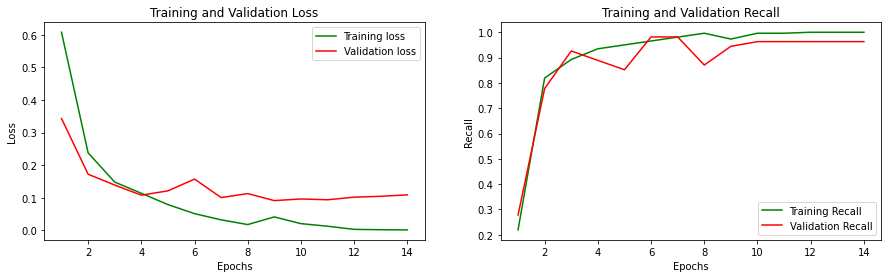

In [16]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall']
val_recall_values = hist_cnn['val_recall']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [17]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 1s 6ms/sample - loss: 0.1091 - acc: 0.9850 - recall: 0.9630
[0.0014380896140128037, 1.0, 1.0] [0.16885365152359008, 0.952, 0.90789473] [0.10910507932305336, 0.985, 0.962963]


## Model iteration 01

This model adds an output layer.

In [22]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [23]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3097632   
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [28]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.3449 - acc: 0.8521 - recall_2: 0.6692 - val_loss: 0.1737 - val_acc: 0.9450 - val_recall_2: 0.8333
Epoch 2/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.2418 - acc: 0.8985 - recall_2: 0.8192 - val_loss: 0.1494 - val_acc: 0.9650 - val_recall_2: 0.8704
Epoch 3/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.1646 - acc: 0.9311 - recall_2: 0.8769 - val_loss: 0.1392 - val_acc: 0.9600 - val_recall_2: 0.8519
Epoch 4/50
798/798 [==============================] - 24s 31ms/sample - loss: 0.1388 - acc: 0.9411 - recall_2: 0.8923 - val_loss: 0.1244 - val_acc: 0.9700 - val_recall_2: 0.8889
Epoch 5/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.1202 - acc: 0.9586 - recall_2: 0.9462 - val_loss: 0.1479 - val_acc: 0.9350 - val_recall_2: 0.9444
Epoch 6/50
798/798 [==============================] - 25s 31ms/s

In [29]:
cnn.save('models/cnn_01')

INFO:tensorflow:Assets written to: models/cnn_01/assets


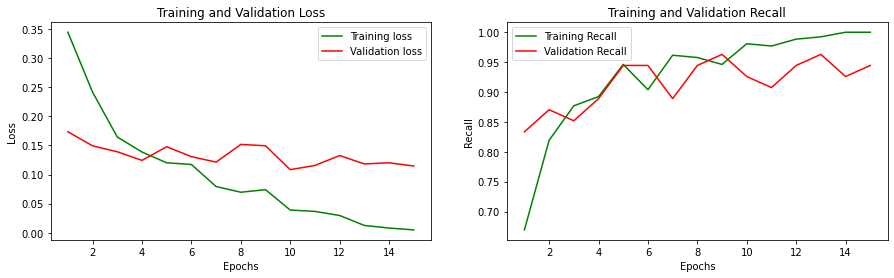

In [32]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_2']
val_recall_values = hist_cnn['val_recall_2']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [33]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 2s 8ms/sample - loss: 0.1147 - acc: 0.9750 - recall_2: 0.9444
[0.0030057059856537813, 1.0, 1.0] [0.17047352296113968, 0.952, 0.92105263] [0.1147029703296721, 0.975, 0.9444444]


## Model iteration 02

This model adds a dropout layer at 20% after the first convolution layer.

In [34]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [35]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

In [36]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 40s 50ms/sample - loss: 0.6020 - acc: 0.6604 - recall_3: 0.2731 - val_loss: 0.3402 - val_acc: 0.8550 - val_recall_3: 0.4630
Epoch 2/50
798/798 [==============================] - 52s 65ms/sample - loss: 0.3000 - acc: 0.8747 - recall_3: 0.7538 - val_loss: 0.1719 - val_acc: 0.9450 - val_recall_3: 0.8333
Epoch 3/50
798/798 [==============================] - 42s 53ms/sample - loss: 0.1461 - acc: 0.9474 - recall_3: 0.9038 - val_loss: 0.1176 - val_acc: 0.9550 - val_recall_3: 0.9259
Epoch 4/50
798/798 [==============================] - 40s 50ms/sample - loss: 0.1352 - acc: 0.9486 - recall_3: 0.9077 - val_loss: 0.1979 - val_acc: 0.9050 - val_recall_3: 0.9630
Epoch 5/50
798/798 [==============================] - 42s 53ms/sample - loss: 0.0890 - acc: 0.9687 - recall_3: 0.9538 - val_loss: 0.0973 - val_acc: 0.9700 - val_recall_3: 0.9259
Epoch 6/50
798/798 [==============================] - 39s 48ms/s

In [37]:
cnn.save('models/cnn_02')

INFO:tensorflow:Assets written to: models/cnn_02/assets


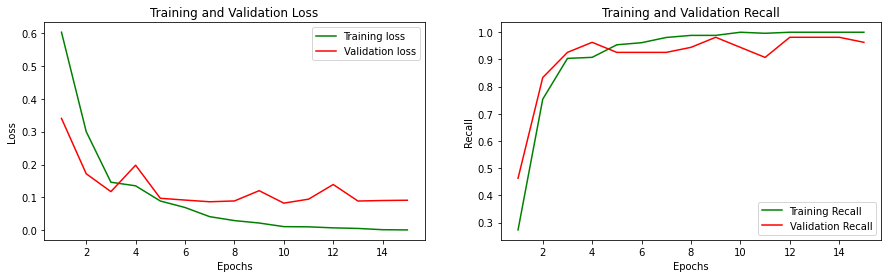

In [39]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_3']
val_recall_values = hist_cnn['val_recall_3']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [40]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 1s 7ms/sample - loss: 0.0913 - acc: 0.9850 - recall_3: 0.9630
[0.0017366126619680856, 1.0, 1.0] [0.16141305327415467, 0.956, 0.93421054] [0.09134157247841358, 0.985, 0.962963]


## Model iteration 03

This model moves the dropout layer at 20% to just before the first pooling layer.

In [41]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [42]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

In [43]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 28s 35ms/sample - loss: 0.6943 - acc: 0.6617 - recall_4: 0.0462 - val_loss: 0.6292 - val_acc: 0.7300 - val_recall_4: 0.0000e+00
Epoch 2/50
798/798 [==============================] - 28s 35ms/sample - loss: 0.5011 - acc: 0.7368 - recall_4: 0.3192 - val_loss: 0.3872 - val_acc: 0.9350 - val_recall_4: 0.8519
Epoch 3/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.2675 - acc: 0.8885 - recall_4: 0.7538 - val_loss: 0.2607 - val_acc: 0.8950 - val_recall_4: 0.9444
Epoch 4/50
798/798 [==============================] - 27s 33ms/sample - loss: 0.1759 - acc: 0.9348 - recall_4: 0.8692 - val_loss: 0.1359 - val_acc: 0.9600 - val_recall_4: 0.9074
Epoch 5/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.1167 - acc: 0.9599 - recall_4: 0.9308 - val_loss: 0.1573 - val_acc: 0.9300 - val_recall_4: 0.9444
Epoch 6/50
798/798 [==============================] - 27s 34

In [44]:
cnn.save('models/cnn_03')

INFO:tensorflow:Assets written to: models/cnn_03/assets


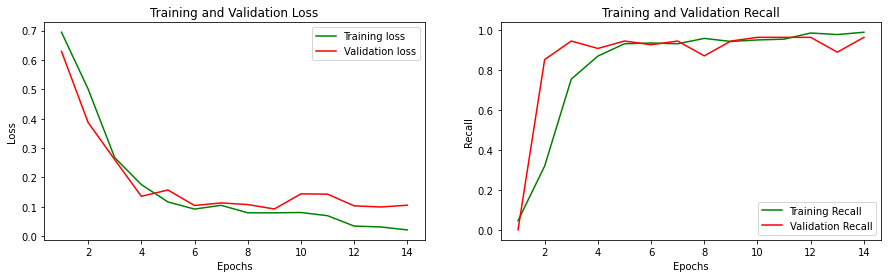

In [45]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_4']
val_recall_values = hist_cnn['val_recall_4']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [46]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 1s 7ms/sample - loss: 0.1056 - acc: 0.9650 - recall_4: 0.9630
[0.012637974983804805, 0.9987469, 1.0] [0.14087474000453948, 0.964, 0.94736844] [0.10556093046441674, 0.965, 0.962963]


## Model iteration 04

This model moves the dropout layer at 20% to the output layers.

In [47]:
# output dropout 0.20
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [48]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                3097632   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [49]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.5597 - acc: 0.6942 - recall_5: 0.1615 - val_loss: 0.3914 - val_acc: 0.8500 - val_recall_5: 0.9259
Epoch 2/50
798/798 [==============================] - 24s 30ms/sample - loss: 0.3082 - acc: 0.8885 - recall_5: 0.7962 - val_loss: 0.1532 - val_acc: 0.9600 - val_recall_5: 0.9074
Epoch 3/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.1782 - acc: 0.9424 - recall_5: 0.8923 - val_loss: 0.1845 - val_acc: 0.9200 - val_recall_5: 0.9259
Epoch 4/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.1244 - acc: 0.9612 - recall_5: 0.9423 - val_loss: 0.1102 - val_acc: 0.9650 - val_recall_5: 0.9074
Epoch 5/50
798/798 [==============================] - 25s 31ms/sample - loss: 0.1099 - acc: 0.9637 - recall_5: 0.9423 - val_loss: 0.1337 - val_acc: 0.9450 - val_recall_5: 0.9444
Epoch 6/50
798/798 [==============================] - 25s 31ms/s

In [50]:
cnn.save('models/cnn_04')

INFO:tensorflow:Assets written to: models/cnn_04/assets


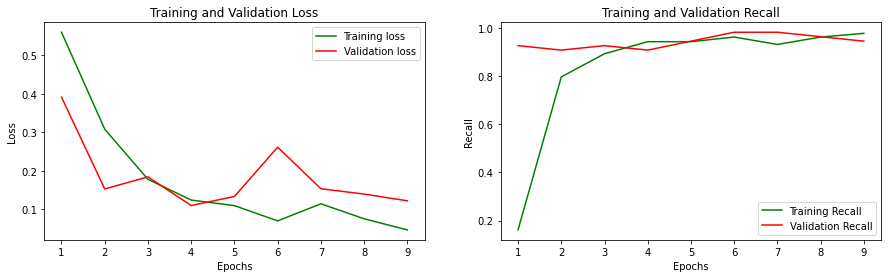

In [51]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_5']
val_recall_values = hist_cnn['val_recall_5']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [52]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 2s 8ms/sample - loss: 0.1225 - acc: 0.9450 - recall_5: 0.9444
[0.022126811974329457, 0.99248123, 0.99615383] [0.1708543622493744, 0.94, 0.94736844] [0.12247972756624222, 0.945, 0.9444444]


## Model iteration 05

This model increases the dropout layer to 35% in the output layers.

In [53]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dropout(0.35))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [54]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                3097632   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [55]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 26s 32ms/sample - loss: 0.6393 - acc: 0.6529 - recall_6: 0.0192 - val_loss: 0.4947 - val_acc: 0.7300 - val_recall_6: 0.0000e+00
Epoch 2/50
798/798 [==============================] - 24s 31ms/sample - loss: 0.4304 - acc: 0.7870 - recall_6: 0.4423 - val_loss: 0.2271 - val_acc: 0.9100 - val_recall_6: 0.9074
Epoch 3/50
798/798 [==============================] - 24s 31ms/sample - loss: 0.2517 - acc: 0.9023 - recall_6: 0.8000 - val_loss: 0.1365 - val_acc: 0.9600 - val_recall_6: 0.9074
Epoch 4/50
798/798 [==============================] - 26s 32ms/sample - loss: 0.1796 - acc: 0.9373 - recall_6: 0.8769 - val_loss: 0.2194 - val_acc: 0.9050 - val_recall_6: 0.9630
Epoch 5/50
798/798 [==============================] - 24s 30ms/sample - loss: 0.1606 - acc: 0.9449 - recall_6: 0.9115 - val_loss: 0.1332 - val_acc: 0.9400 - val_recall_6: 0.9259
Epoch 6/50
798/798 [==============================] - 25s 31

In [56]:
cnn.save('models/cnn_05')

INFO:tensorflow:Assets written to: models/cnn_05/assets


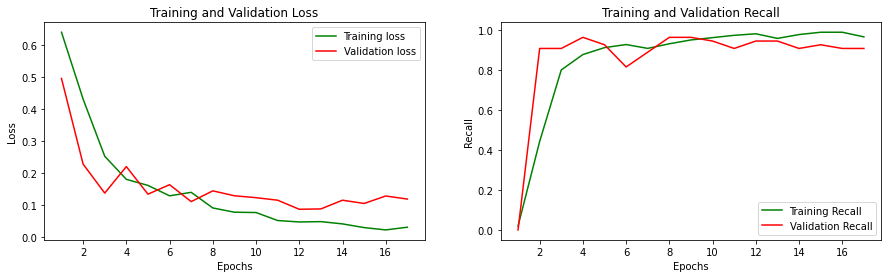

In [58]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_6']
val_recall_values = hist_cnn['val_recall_6']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [59]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 2s 8ms/sample - loss: 0.1179 - acc: 0.9700 - recall_6: 0.9074
[0.004995049846902452, 1.0, 1.0] [0.19776352763175964, 0.944, 0.90789473] [0.11790354375727474, 0.97, 0.9074074]


## Model iteration 06

This model adds dropout layers at 20% to the hidden and output layers.

In [60]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [61]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)               

In [62]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 28s 35ms/sample - loss: 0.7844 - acc: 0.6491 - recall_7: 0.0577 - val_loss: 0.6210 - val_acc: 0.7300 - val_recall_7: 0.0000e+00
Epoch 2/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.5221 - acc: 0.6967 - recall_7: 0.0731 - val_loss: 0.3598 - val_acc: 0.9100 - val_recall_7: 0.6667
Epoch 3/50
798/798 [==============================] - 30s 38ms/sample - loss: 0.3376 - acc: 0.8722 - recall_7: 0.6885 - val_loss: 0.2859 - val_acc: 0.9050 - val_recall_7: 0.9259
Epoch 4/50
798/798 [==============================] - 28s 35ms/sample - loss: 0.2593 - acc: 0.9223 - recall_7: 0.8577 - val_loss: 0.1392 - val_acc: 0.9600 - val_recall_7: 0.8889
Epoch 5/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.1716 - acc: 0.9386 - recall_7: 0.8731 - val_loss: 0.1615 - val_acc: 0.9400 - val_recall_7: 0.9259
Epoch 6/50
798/798 [==============================] - 27s 34

In [63]:
cnn.save('models/cnn_06')

INFO:tensorflow:Assets written to: models/cnn_06/assets


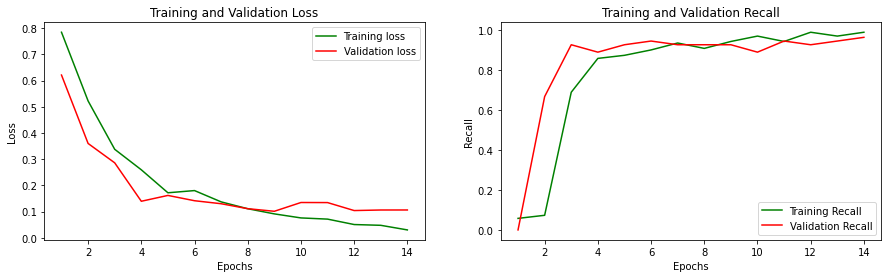

In [64]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_7']
val_recall_values = hist_cnn['val_recall_7']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [65]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 1s 7ms/sample - loss: 0.1059 - acc: 0.9800 - recall_7: 0.9630
[0.00980300872462958, 0.9987469, 1.0] [0.1739767336845398, 0.944, 0.92105263] [0.10591638097539544, 0.98, 0.962963]


## Model iteration 07

This model increases the dropout layer in the hidden layers to 35%.

In [66]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.35))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [67]:
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)              

In [68]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 28s 35ms/sample - loss: 1.1367 - acc: 0.6667 - recall_8: 0.0346 - val_loss: 0.6456 - val_acc: 0.7300 - val_recall_8: 0.0000e+00
Epoch 2/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.5394 - acc: 0.7055 - recall_8: 0.0962 - val_loss: 0.4318 - val_acc: 0.8350 - val_recall_8: 0.3889
Epoch 3/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.3773 - acc: 0.8584 - recall_8: 0.6000 - val_loss: 0.3556 - val_acc: 0.9150 - val_recall_8: 0.9074
Epoch 4/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.3279 - acc: 0.9273 - recall_8: 0.8308 - val_loss: 0.3113 - val_acc: 0.9500 - val_recall_8: 0.9259
Epoch 5/50
798/798 [==============================] - 27s 34ms/sample - loss: 0.3040 - acc: 0.9348 - recall_8: 0.8462 - val_loss: 0.3330 - val_acc: 0.9450 - val_recall_8: 0.9815
Epoch 6/50
798/798 [==============================] - 28s 35

In [69]:
cnn.save('models/cnn_07')

INFO:tensorflow:Assets written to: models/cnn_07/assets


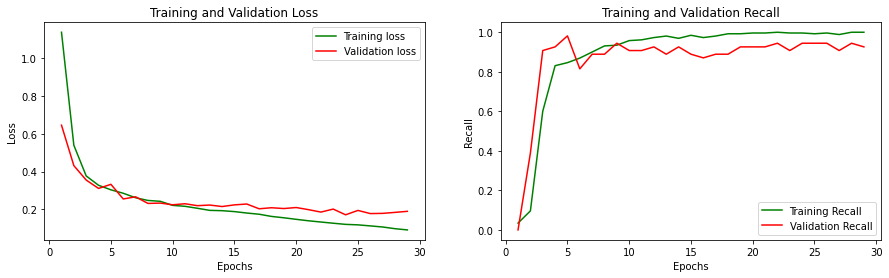

In [70]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_8']
val_recall_values = hist_cnn['val_recall_8']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [71]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 2s 8ms/sample - loss: 0.1903 - acc: 0.9700 - recall_8: 0.9259
[0.08967146682634689, 0.9962406, 1.0] [0.2152061972618103, 0.956, 0.90789473] [0.19030990123748778, 0.97, 0.9259259]


## Model iteration 08

This model increases the dropout layer in the hidden layers to 50%.

In [72]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=X_train[0].shape,
                      padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc',tensorflow.keras.metrics.Recall()])

In [73]:
cnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 96800)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)              

In [74]:
# Save the weights for each layer
saving_weights = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

#
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)

#
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()

#
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)

#
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

#
cnn_fit = cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 798 samples, validate on 200 samples
Epoch 1/50
798/798 [==============================] - 29s 37ms/sample - loss: 0.8554 - acc: 0.6316 - recall_9: 0.1192 - val_loss: 0.6902 - val_acc: 0.7300 - val_recall_9: 0.0000e+00
Epoch 2/50
798/798 [==============================] - 28s 35ms/sample - loss: 0.6122 - acc: 0.6742 - recall_9: 0.0000e+00 - val_loss: 0.5524 - val_acc: 0.7300 - val_recall_9: 0.0000e+00
Epoch 3/50
798/798 [==============================] - 30s 37ms/sample - loss: 0.4846 - acc: 0.7556 - recall_9: 0.2615 - val_loss: 0.3770 - val_acc: 0.9150 - val_recall_9: 0.8889
Epoch 4/50
798/798 [==============================] - 29s 37ms/sample - loss: 0.2724 - acc: 0.8910 - recall_9: 0.7808 - val_loss: 0.1906 - val_acc: 0.9450 - val_recall_9: 0.8333
Epoch 5/50
798/798 [==============================] - 30s 38ms/sample - loss: 0.1787 - acc: 0.9361 - recall_9: 0.8615 - val_loss: 0.2554 - val_acc: 0.9100 - val_recall_9: 0.9444
Epoch 6/50
798/798 [==============================] 

In [75]:
cnn.save('models/cnn_08')

INFO:tensorflow:Assets written to: models/cnn_08/assets


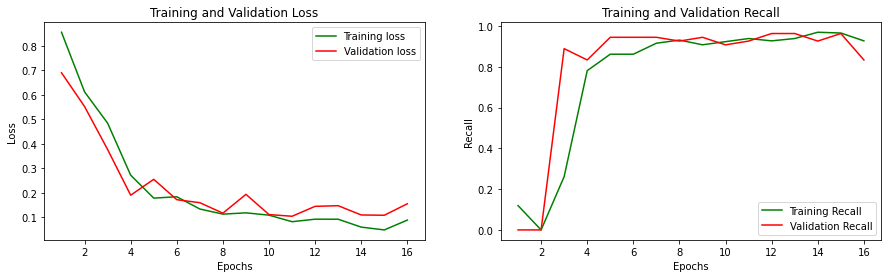

In [76]:
hist_cnn = cnn_fit.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']
recall_values = hist_cnn['recall_9']
val_recall_values = hist_cnn['val_recall_9']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, recall_values, 'g', label='Training Recall')
plt.plot(epochs, val_recall_values, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [77]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
results_val =  cnn.evaluate(X_val, y_val)

print(results_train, results_test, results_val)

200/200 [==============================] - 1s 7ms/sample - loss: 0.1557 - acc: 0.9500 - recall_9: 0.8333
[0.12948777681604065, 0.95739347, 0.8730769] [0.19832123136520385, 0.916, 0.7894737] [0.1557453191280365, 0.95, 0.8333333]
